In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from model import load_model, preprocess
import os
import torch

In [14]:
embd_full = np.load("embeddings/img_emb_0.npy")
embd_full 

array([[-0.00818 , -0.04932 , -0.0381  , ...,  0.002457, -0.03467 ,
        -0.02283 ],
       [ 0.03223 ,  0.01746 , -0.01428 , ...,  0.0199  , -0.01685 ,
         0.02686 ],
       [ 0.0349  , -0.02197 , -0.01294 , ...,  0.02649 ,  0.02124 ,
        -0.008484],
       ...,
       [-0.03394 ,  0.01361 , -0.04688 , ..., -0.006927,  0.03442 ,
        -0.00958 ],
       [-0.012695, -0.01074 ,  0.002045, ...,  0.00952 , -0.0635  ,
         0.01007 ],
       [-0.0299  ,  0.00842 ,  0.02026 , ..., -0.03027 ,  0.01349 ,
         0.0498  ]], dtype=float16)

In [23]:
image_dir = os.listdir("images")
img_index = sorted(list(map(lambda sub:int(''.join(
      [ele for ele in sub if ele.isnumeric()])), image_dir)))

ValueError: invalid literal for int() with base 10: ''

In [18]:
print(embd_full.shape)
print(len(img_index))

(36125, 1024)
36125


In [19]:
indv_embd_ex = embd_full[0]
type(indv_embd_ex)

numpy.ndarray

In [20]:
from sklearn import cluster
n_clusters=500

embd_data = pd.DataFrame(embd_full)
clusters = cluster.KMeans(n_clusters).fit(embd_data)
cluster_map = pd.DataFrame()
# cluster_map['data_index'] = [img_index[i] for i in embd_data.index.values]
cluster_map['data_index'] = embd_data.index.values
cluster_map['label'] = clusters.labels_

In [213]:
# cluster_map.to_pickle("./full_emd.pkl")
# unpickled_df = pd.read_pickle("./full_emd.pkl")   

In [2]:
import gradio as gr
import torch
from model import preprocess, load_model
from transformers import CLIPModel, CLIPProcessor

model = load_model("models/aesthetics_scorer_rating_openclip_vit_h_14.pth")
MODEL = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CLIPModel.from_pretrained(MODEL)
vision_model = model.vision_model
vision_model.to(DEVICE)
del model
clip_processor = CLIPProcessor.from_pretrained(MODEL)

rating_model = load_model("models/aesthetics_scorer_rating_openclip_vit_h_14.pth").to(DEVICE)
artifacts_model = load_model("models/aesthetics_scorer_artifacts_openclip_vit_h_14.pth").to(DEVICE)

def predict(img):
    inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        vision_output = vision_model(**inputs)
    pooled_output = vision_output.pooler_output
    embedding = preprocess(pooled_output)
    with torch.no_grad():
        rating = rating_model(embedding)
        artifact = artifacts_model(embedding)
    return rating.detach().cpu().item(), artifact.detach().cpu().item()


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
2023-04-19 09:18:50.710542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
cluster_pd = pd.DataFrame(columns = ["label","img_idx", "center", "rating_score", "aest_score"])
cluster_pd["label"] = list(range(n_clusters))
cluster_pd["img_idx"] = [np.array(cluster_map[cluster_map['label'] == x]["data_index"]) for x in range(n_clusters)]
cluster_pd["center"] = list(clusters.cluster_centers_)                                          

In [25]:
cluster_pd

,label,img_idx,center,rating_score,aest_score
0,0,"[1717, 4165, 5567, 6884, 8560, 8817, 9069, 124...","[-0.0069408416748046875, -0.001300811767578123...",NaN,NaN
1,1,"[92, 432, 679, 2719, 5136, 6075, 6146, 6577, 7...","[-0.0007424965882912677, 0.012880912193885222,...",NaN,NaN
2,2,"[109, 144, 478, 564, 585, 1908, 2095, 2264, 25...","[0.006140124413274948, -0.013523963189894152, ...",NaN,NaN
3,3,"[162, 1659, 1920, 2168, 3978, 4128, 4674, 5261...","[0.001089027949741906, 0.002168655395507814, 0...",NaN,NaN
4,4,"[21, 1127, 1260, 1986, 2041, 2993, 4338, 4720,...","[-0.016064270682956863, 0.007230122884114586, ...",NaN,NaN
...,...,...,...,...,...
495,495,"[85, 342, 666, 673, 1063, 1256, 1466, 1616, 20...","[-0.0006895798903245208, -0.005415633702889466...",NaN,NaN
496,496,"[618, 644, 2624, 2842, 3149, 3246, 3272, 3366,...","[0.007192054352202972, 0.006923328746448866, 0...",NaN,NaN
497,497,"[413, 5600, 8727, 9223, 11153, 13220, 15624, 1...","[0.011936823527018223, 0.00568249821662903, 0....",NaN,NaN
498,498,"[2118, 3268, 3347, 3870, 4220, 4274, 6303, 704...","[-0.0007574898856026789, -0.00705329739317602,...",NaN,NaN


In [9]:
curr_embd = 1
cluster_pd_pickle = pd.read_pickle("./full_emd_score" + str(curr_embd) + ".pkl")   
cluster_pd_pickle

,label,img_idx,center,rating_score,aest_score
0,0,"[1717, 4165, 5567, 6884, 8560, 8817, 9069, 124...","[-0.0069408416748046875, -0.001300811767578123...",4.083333,2.208333
1,1,"[92, 432, 679, 2719, 5136, 6075, 6146, 6577, 7...","[-0.0007424965882912677, 0.012880912193885222,...",3.987179,2.538462
2,2,"[109, 144, 478, 564, 585, 1908, 2095, 2264, 25...","[0.006140124413274948, -0.013523963189894152, ...",NaN,NaN
3,3,"[162, 1659, 1920, 2168, 3978, 4128, 4674, 5261...","[0.001089027949741906, 0.002168655395507814, 0...",NaN,NaN
4,4,"[21, 1127, 1260, 1986, 2041, 2993, 4338, 4720,...","[-0.016064270682956863, 0.007230122884114586, ...",NaN,NaN
...,...,...,...,...,...
495,495,"[85, 342, 666, 673, 1063, 1256, 1466, 1616, 20...","[-0.0006895798903245208, -0.005415633702889466...",NaN,NaN
496,496,"[618, 644, 2624, 2842, 3149, 3246, 3272, 3366,...","[0.007192054352202972, 0.006923328746448866, 0...",NaN,NaN
497,497,"[413, 5600, 8727, 9223, 11153, 13220, 15624, 1...","[0.011936823527018223, 0.00568249821662903, 0....",NaN,NaN
498,498,"[2118, 3268, 3347, 3870, 4220, 4274, 6303, 704...","[-0.0007574898856026789, -0.00705329739317602,...",NaN,NaN


In [8]:
# cluster_pd = pd.read_pickle("./full_emd_score" + str(curr_embd) + ".pkl")   
for idx in range(curr_embd + 1, 500): 
    print("current cluster: " + str(idx))
    curr_clus_img_list = cluster_pd_pickle["img_idx"][idx]
    print(len(curr_clus_img_list))
    clus_rating_score = 0 #high is good
    clus_artif_score = 0 #low is good 
    for curr_img_idx in curr_clus_img_list: 
        img_path = "images/" + image_dir[curr_img_idx]
        clus_pred = predict(plt.imread(img_path))
        clus_rating_score += int(clus_pred[0])
        clus_artif_score += int(clus_pred[1])
    cluster_pd_pickle.loc[idx,"rating_score"] = clus_rating_score / len(curr_clus_img_list)
    cluster_pd_pickle.loc[idx,"aest_score"] = clus_artif_score / len(curr_clus_img_list)
    cluster_pd_pickle.to_pickle("./full_emd_score" + str(idx) + ".pkl")
    

current cluster: 1
78
current cluster: 2
62


KeyboardInterrupt: 

In [29]:
pd.read_pickle("./full_emd_score0.pkl")   

,label,img_idx,center,rating_score,aest_score
0,0,"[1717, 4165, 5567, 6884, 8560, 8817, 9069, 124...","[-0.0069408416748046875, -0.001300811767578123...",4.083333,2.208333
1,1,"[92, 432, 679, 2719, 5136, 6075, 6146, 6577, 7...","[-0.0007424965882912677, 0.012880912193885222,...",NaN,NaN
2,2,"[109, 144, 478, 564, 585, 1908, 2095, 2264, 25...","[0.006140124413274948, -0.013523963189894152, ...",NaN,NaN
3,3,"[162, 1659, 1920, 2168, 3978, 4128, 4674, 5261...","[0.001089027949741906, 0.002168655395507814, 0...",NaN,NaN
4,4,"[21, 1127, 1260, 1986, 2041, 2993, 4338, 4720,...","[-0.016064270682956863, 0.007230122884114586, ...",NaN,NaN
...,...,...,...,...,...
495,495,"[85, 342, 666, 673, 1063, 1256, 1466, 1616, 20...","[-0.0006895798903245208, -0.005415633702889466...",NaN,NaN
496,496,"[618, 644, 2624, 2842, 3149, 3246, 3272, 3366,...","[0.007192054352202972, 0.006923328746448866, 0...",NaN,NaN
497,497,"[413, 5600, 8727, 9223, 11153, 13220, 15624, 1...","[0.011936823527018223, 0.00568249821662903, 0....",NaN,NaN
498,498,"[2118, 3268, 3347, 3870, 4220, 4274, 6303, 704...","[-0.0007574898856026789, -0.00705329739317602,...",NaN,NaN


In [21]:
cluster_pd_pickle = pd.read_pickle("./full_emd_score" + str(499) + ".pkl")   

In [25]:
import math
from matplotlib import gridspec

def subplot_cluster(cluster_pd, img_plt_idx):
    img_idx_list = cluster_pd["img_idx"][img_plt_idx]
    N = len(img_idx_list)
    cols = 3
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    fig.suptitle("cluster " + str(img_plt_idx) + " with rating of " +  str(cluster_pd["rating_score"][img_plt_idx]))
    for n in range(N):
        img_path = "images/" + image_dir[img_idx_list[n]]
        ax = fig.add_subplot(gs[n])
        ax.imshow(plt.imread(img_path))
    fig.tight_layout()
    

/var/folders/vw/smh4j2rd0nbd3nv6602hrfs40000gn/T/ipykernel_4900/1178926630.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


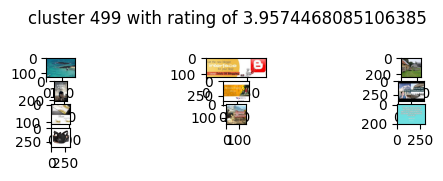

In [26]:
subplot_cluster(cluster_pd_pickle, 499)

In [40]:
cluster_pd_pickle

,label,img_idx,center,rating_score,aest_score
0,0,"[1717, 4165, 5567, 6884, 8560, 8817, 9069, 124...","[-0.0069408416748046875, -0.001300811767578123...",4.083333,2.208333
1,1,"[92, 432, 679, 2719, 5136, 6075, 6146, 6577, 7...","[-0.0007424965882912677, 0.012880912193885222,...",3.987179,2.538462
2,2,"[109, 144, 478, 564, 585, 1908, 2095, 2264, 25...","[0.006140124413274948, -0.013523963189894152, ...",3.693548,2.66129
3,3,"[162, 1659, 1920, 2168, 3978, 4128, 4674, 5261...","[0.001089027949741906, 0.002168655395507814, 0...",4.0,2.428571
4,4,"[21, 1127, 1260, 1986, 2041, 2993, 4338, 4720,...","[-0.016064270682956863, 0.007230122884114586, ...",4.0,2.376812
...,...,...,...,...,...
495,495,"[85, 342, 666, 673, 1063, 1256, 1466, 1616, 20...","[-0.0006895798903245208, -0.005415633702889466...",4.012821,2.410256
496,496,"[618, 644, 2624, 2842, 3149, 3246, 3272, 3366,...","[0.007192054352202972, 0.006923328746448866, 0...",3.87013,2.454545
497,497,"[413, 5600, 8727, 9223, 11153, 13220, 15624, 1...","[0.011936823527018223, 0.00568249821662903, 0....",3.958333,2.291667
498,498,"[2118, 3268, 3347, 3870, 4220, 4274, 6303, 704...","[-0.0007574898856026789, -0.00705329739317602,...",4.183673,2.285714


Text(0, 0.5, 'count of clusters')

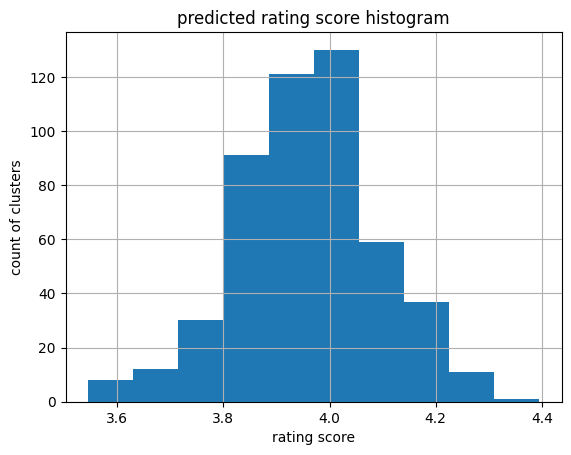

In [53]:
plt.subplot(1,1,1)
rating_hist = cluster_pd_pickle["rating_score"].hist(bins = 10)
plt.title("predicted rating score histogram")
plt.xlabel("rating score")
plt.ylabel("count of clusters")


Text(0.5, 1.0, 'predicted aesthetic score histogram')

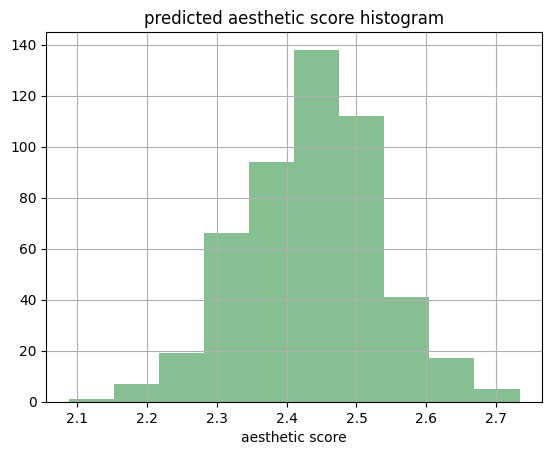

In [52]:
plt.subplot(1,1,1)
aest_hist = cluster_pd_pickle["aest_score"].hist(bins = 10, color='#86bf91')
plt.xlabel("aesthetic score")
plt.ylabel("count of clusters")
plt.title("predicted aesthetic score histogram")